In [ ]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
def showgraphs(model, X, n_hidden1=12, n_hidden2=8, n_output=2,epoch=1):
    x_range = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
    y_range = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100)
    X_mesh, Y_mesh = np.meshgrid(x_range, y_range)
    input_data = np.c_[X_mesh.ravel(), Y_mesh.ravel()]

    # Convert meshgrid to PyTorch tensor
    input_data_torch = torch.tensor(input_data, dtype=torch.float32)

    # Make predictions (raw logits) from the trained model
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        hidden_output1, hidden_output2, final_output = model(input_data_torch)

    # Convert output to numpy for plotting
    hidden_output_np1 = hidden_output1.numpy().reshape(X_mesh.shape[0], X_mesh.shape[1], n_hidden1)
    hidden_output_np2 = hidden_output2.numpy().reshape(X_mesh.shape[0], X_mesh.shape[1], n_hidden2)
    final_output_np = final_output.numpy().reshape(X_mesh.shape[0], X_mesh.shape[1], n_output)

    # Step 5: Plot the results
    fig = plt.figure(figsize=(18, 18))  # Adjusted figure size for better layout

    # Overall title for the whole figure
    plt.suptitle(f'Hidden Layer and Output Activations after epoch {epoch}', fontsize=20)

    # Plot for each node in the first hidden layer (12 hidden nodes)
    for i in range(n_hidden1):
        ax = fig.add_subplot(6, 4, i + 1, projection='3d')  # 6x4 grid for better spacing
        ax.plot_surface(X_mesh, Y_mesh, hidden_output_np1[:, :, i], cmap='coolwarm', edgecolor='none')
        ax.set_title(f'Hidden Layer 1 Node {i+1} Output (Tanh)', fontsize=10)
        ax.set_xlabel('Input X1')
        ax.set_ylabel('Input X2')
        ax.set_zlabel('Hidden Node Output')

    # Plot for each node in the second hidden layer (8 hidden nodes)
    for i in range(n_hidden2):
        ax = fig.add_subplot(6, 4, n_hidden1 + i + 1, projection='3d')  # Continue in the grid
        ax.plot_surface(X_mesh, Y_mesh, hidden_output_np2[:, :, i], cmap='coolwarm', edgecolor='none')
        ax.set_title(f'Hidden Layer 2 Node {i+1} Output (Tanh)', fontsize=10)
        ax.set_xlabel('Input X1')
        ax.set_ylabel('Input X2')
        ax.set_zlabel('Hidden Node Output')

    # Plot for the output layer (2 output nodes)
    for i in range(n_output):
        ax = fig.add_subplot(6, 4, n_hidden1 + n_hidden2 + i + 1, projection='3d')
        ax.plot_surface(X_mesh, Y_mesh, final_output_np[:, :, i], cmap='coolwarm', edgecolor='none')
        ax.set_title(f'Output Layer Node {i+1} (Softmax)', fontsize=10)
        ax.set_xlabel('Input X1')
        ax.set_ylabel('Input X2')
        ax.set_zlabel('Output Node Logits')

    # Adjust spacing between subplots for better layout
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.savefig(f"NNlayer{epoch}.png", format="png")
    plt.show()


In [ ]:
def calculate_accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    correct_predictions = np.sum(y_true == y_pred)
    total_samples = y_true.shape[0]
    accuracy = correct_predictions / total_samples
    return accuracy

def confusion_matrix(y_true, y_pred, labels=None):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    if labels is None:
        labels = np.unique(np.concatenate((y_true, y_pred)))
    label_to_index = {label: idx for idx, label in enumerate(labels)}
    cm = np.zeros((len(labels), len(labels)), dtype=int)
    for true_label, pred_label in zip(y_true, y_pred):
        true_idx = label_to_index[true_label]
        pred_idx = label_to_index[pred_label]
        cm[true_idx, pred_idx] += 1
    return cm

def plot_confusion_matrix(y_true, y_pred, labels=None):
    if labels is None:
        labels = np.unique(np.concatenate((y_true, y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels)

    # Create the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

def confusion_matrix_to_dataframe(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    df = pd.DataFrame(cm, index=labels, columns=labels)
    df.index.name = 'Actual'
    df.columns.name = 'Predicted'
    return df

def create_table(y_true,y_pred,labels=None,title="Confuion matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=labels).T
    df = pd.DataFrame(cm, index=labels, columns=labels)
    df.columns = labels
    df.index.name = 'Prediction'
    df = df.reset_index()
    df.rename(columns={'index': 'Prediction'}, inplace=True)
    fig = plt.figure(figsize=(5,2))
    ax=fig.gca()
    ax.axis('off')
    ax.set_title(title)
    r,c = df.shape
    table = ax.table(cellText=np.vstack([['']+['Actual']+[''] * (len(labels)-1), df.columns, df.values]),
                     cellColours=[['none']*c]*(2 + r), bbox=[0, 0, 1, 1])
    fig.canvas.draw()
    table[(0, 0)].visible_edges = 'TLR'
    table[(1, 0)].visible_edges = 'BLR'
    cell = table[(0, len(labels))].visible_edges = 'BTR'
    for i in range(1,len(labels)):
        table[(0, i)].visible_edges = 'BT'
    table[(0, len(labels))].visible_edges = 'BTR'

In [ ]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        _,_,y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels

    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


In [ ]:
train=pd.read_csv('Dataset-3/Train.csv')
test=pd.read_csv('Dataset-3/Test.csv')
val=pd.read_csv('Dataset-3/Val.csv')


In [ ]:
X_train=train.iloc[:, :-1].to_numpy()
y_train=train.iloc[:, -1].to_numpy()

X_test=test.iloc[:, :-1].to_numpy()
y_test=test.iloc[:, -1].to_numpy()

X_val=val.iloc[:, :-1].to_numpy()
y_val=val.iloc[:, -1].to_numpy()


In [ ]:
X_train = torch.from_numpy(X_train).type(torch.float32)  # Convert to torch tensor
y_train = torch.from_numpy(y_train).type(torch.long)
X_test = torch.from_numpy(X_test).type(torch.float32)  # Convert to torch tensor
y_test = torch.from_numpy(y_test).type(torch.long)

In [ ]:
X_train.shape,y_train

(torch.Size([561, 2]),
 tensor([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
         1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
         1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
         1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
         1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
         1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
         1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
         1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
         0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
         0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
         1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
     

In [ ]:
import torch
import torch.nn as nn

class Question3(nn.Module):
    def __init__(self):
        super(Question3, self).__init__()
        self.hidden_layer1 = nn.Linear(2, 12)  # Input layer to first hidden layer
        self.hidden_layer2 = nn.Linear(12, 8)  # First hidden layer to second hidden layer
        self.output_layer = nn.Linear(8, 2)   # Second hidden layer to output layer (12 classes)

    def forward(self, x):
        h1 = torch.tanh(self.hidden_layer1(x))  # Activation function for the first hidden layer
        h2 = torch.tanh(self.hidden_layer2(h1))  # Activation function for the second hidden layer
        return h1,h2,torch.softmax(self.output_layer(h2), dim=1)  # Softmax for the output layer
model=Question3()

Epoch: 0 | Loss: 0.69421, Train Acc: 50.98% | Test Loss: 0.70705, Test Acc: 42.50%


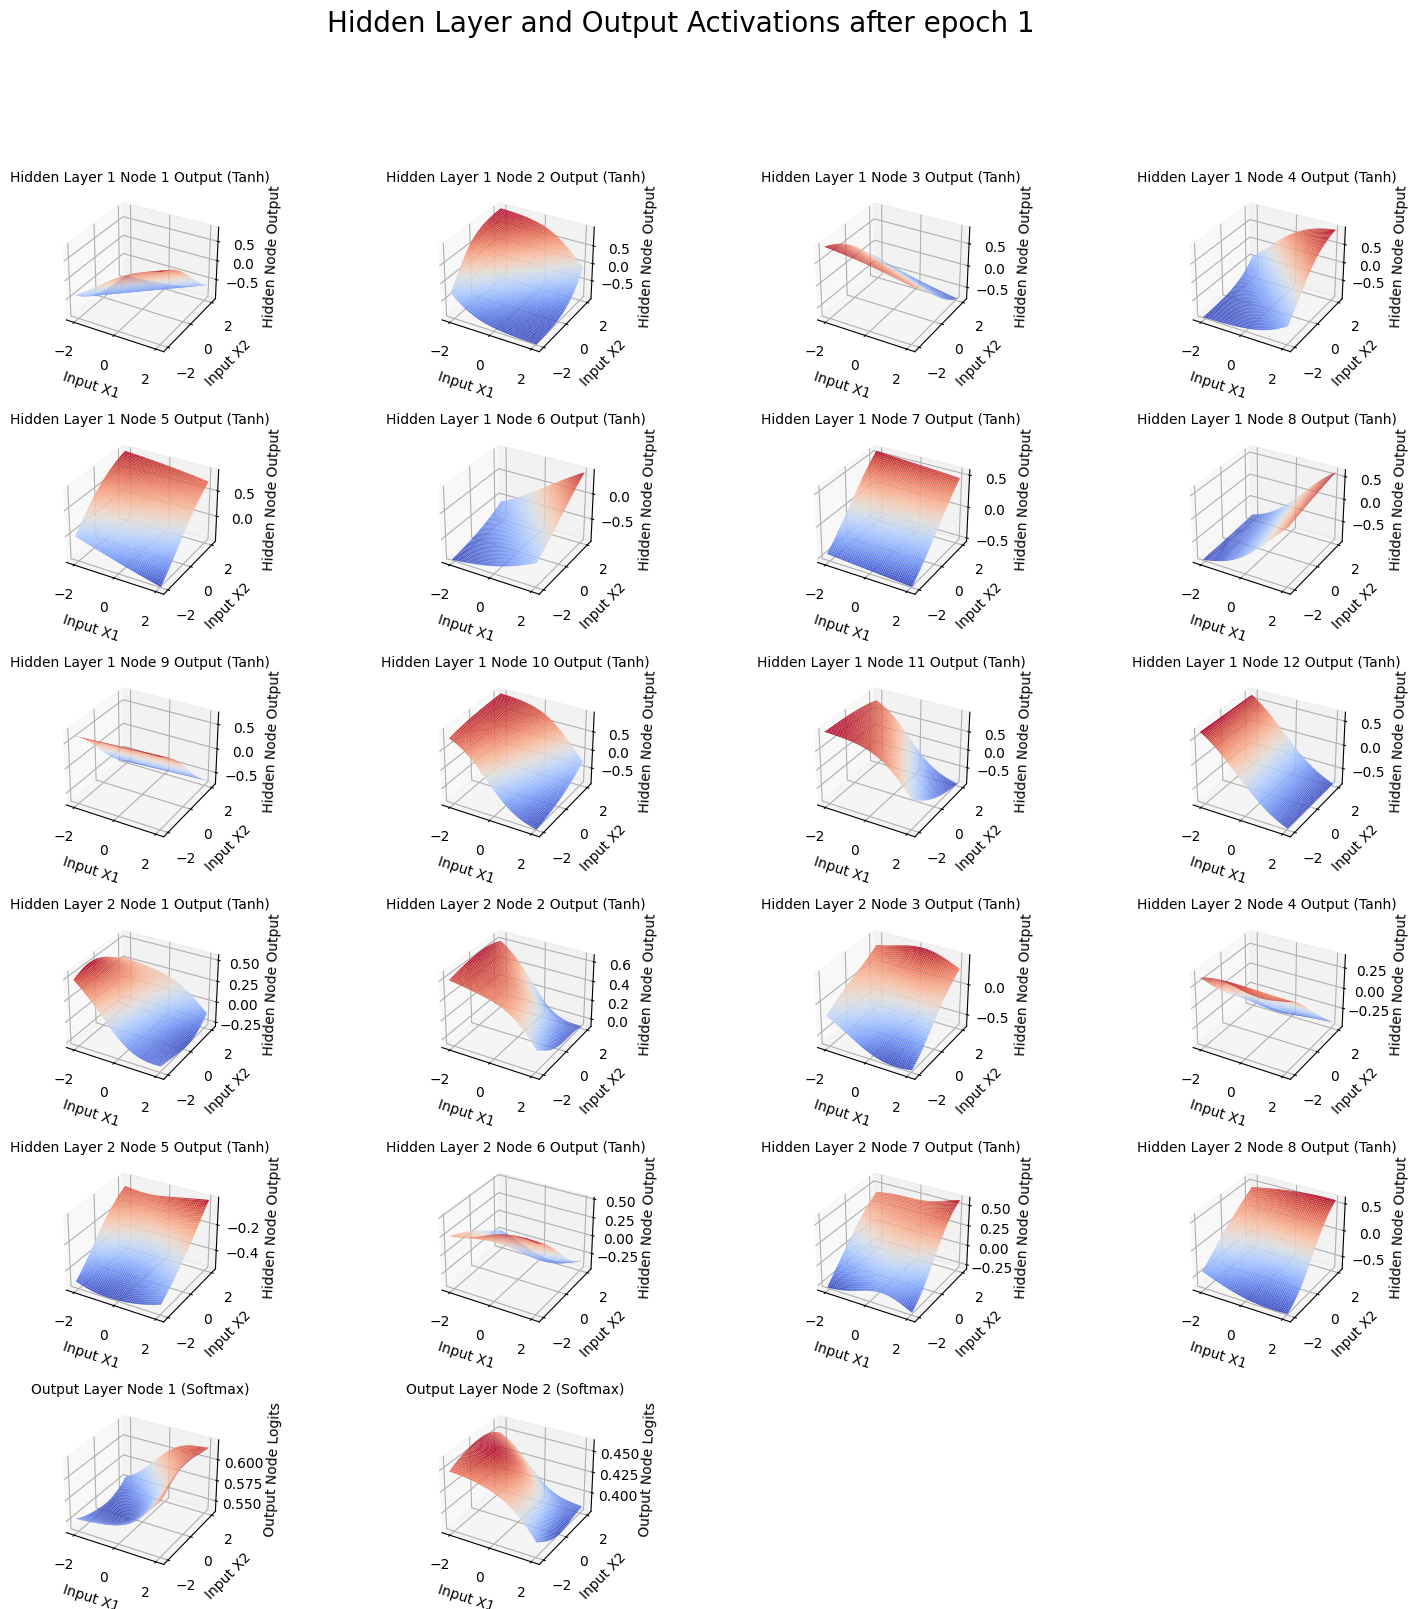

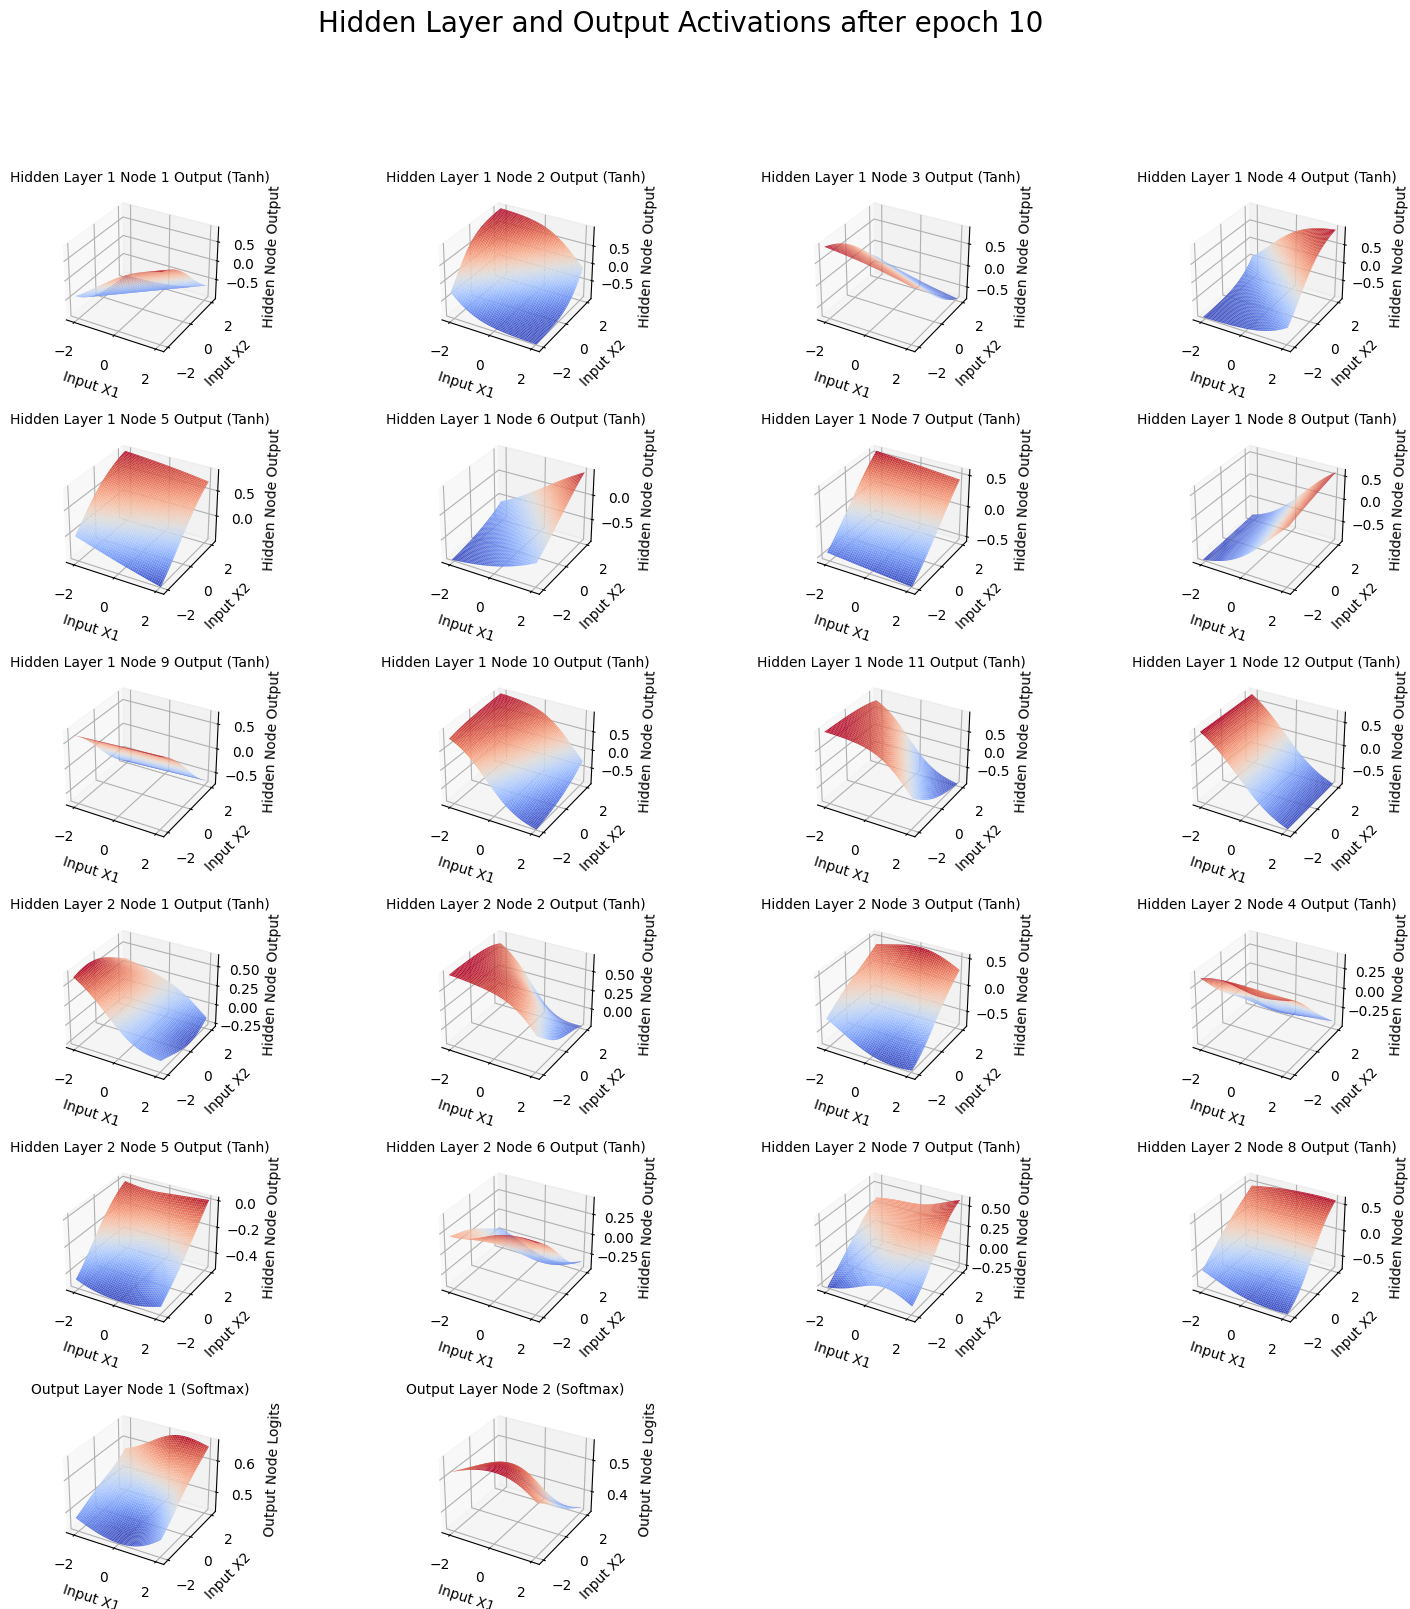

Epoch: 10 | Loss: 0.68997, Train Acc: 52.05% | Test Loss: 0.69324, Test Acc: 52.50%
Epoch: 20 | Loss: 0.68677, Train Acc: 54.55% | Test Loss: 0.68570, Test Acc: 57.50%
Epoch: 30 | Loss: 0.67616, Train Acc: 60.61% | Test Loss: 0.67636, Test Acc: 67.50%
Epoch: 40 | Loss: 0.64342, Train Acc: 73.08% | Test Loss: 0.64501, Test Acc: 71.25%


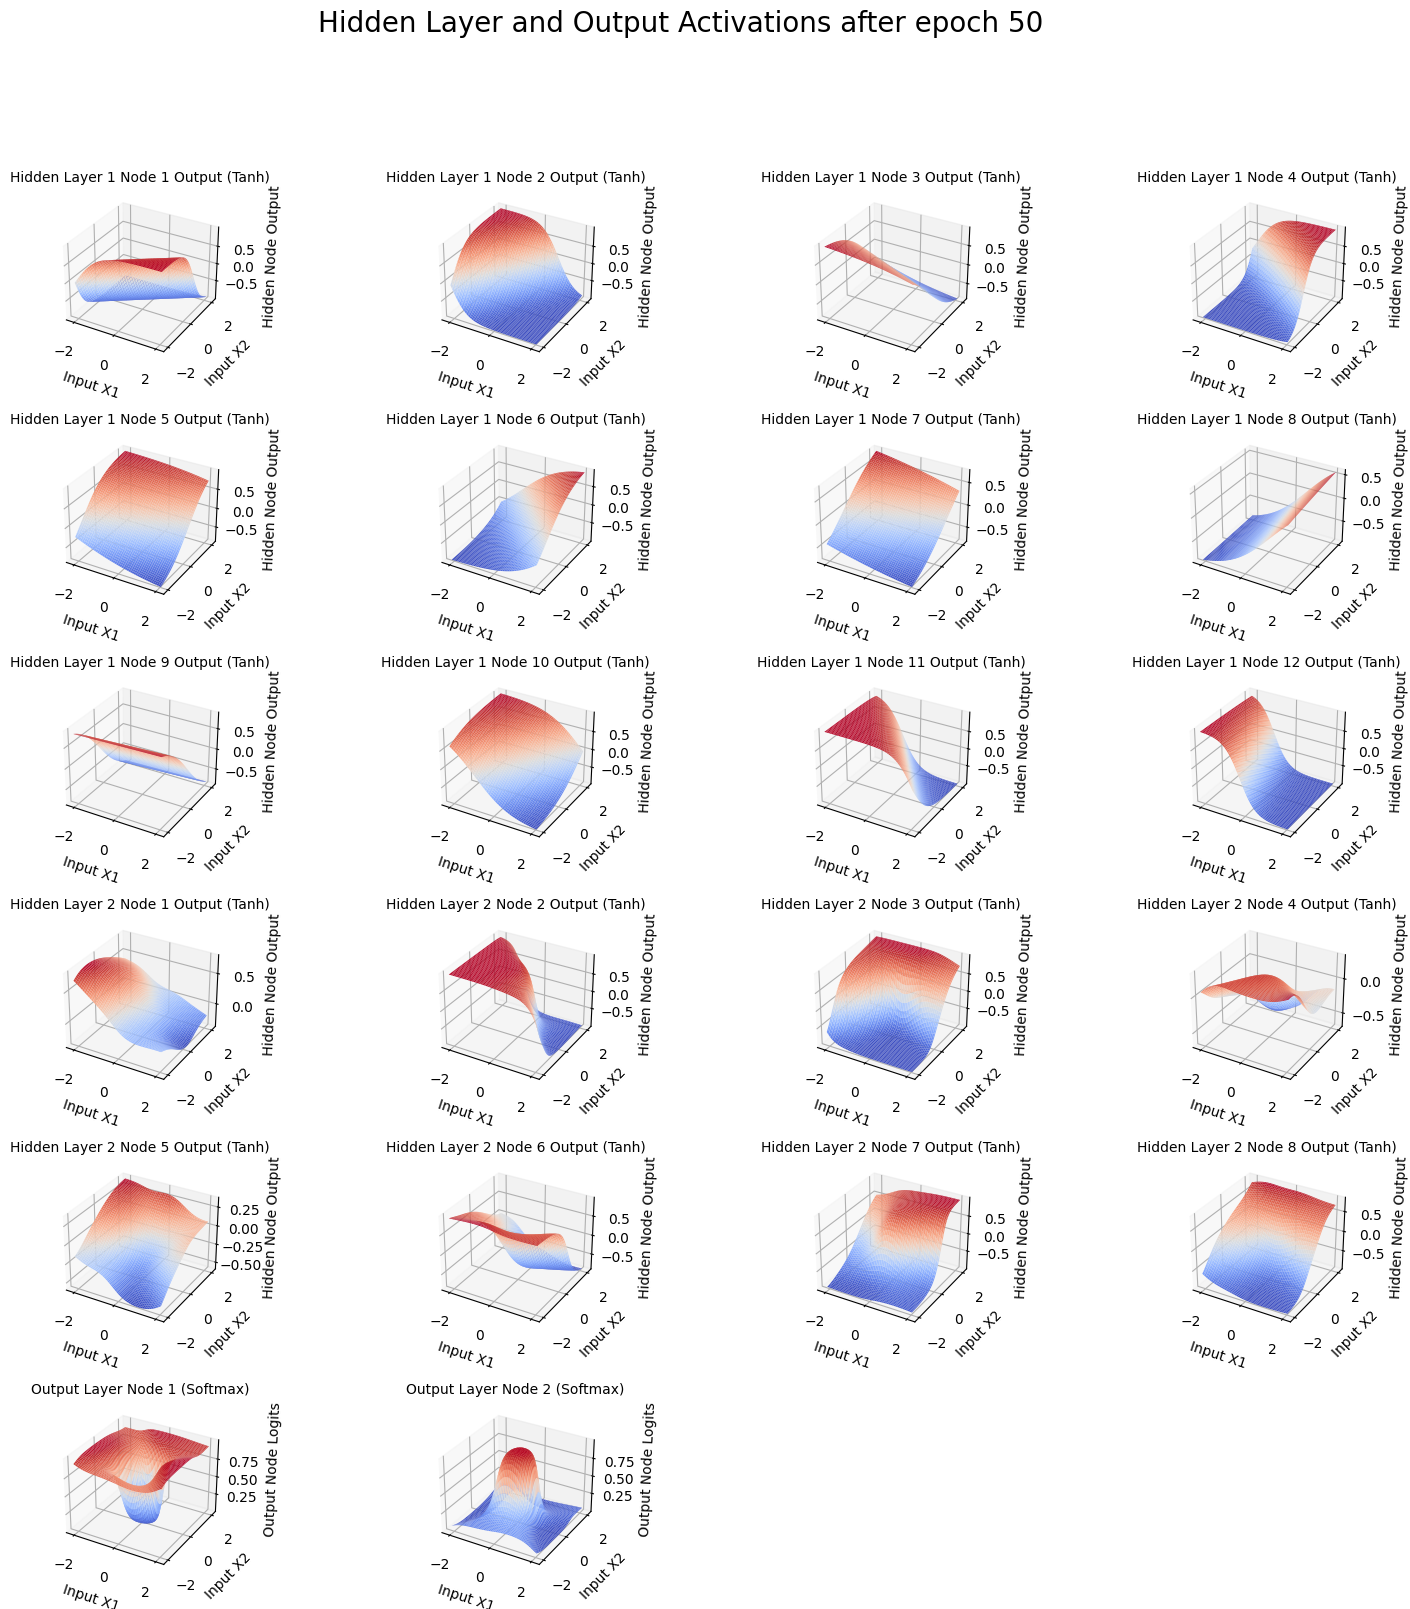

Epoch: 50 | Loss: 0.56105, Train Acc: 90.91% | Test Loss: 0.54902, Test Acc: 93.75%
Epoch: 60 | Loss: 0.44233, Train Acc: 97.33% | Test Loss: 0.44455, Test Acc: 96.25%
Epoch: 70 | Loss: 0.64438, Train Acc: 65.06% | Test Loss: 0.58715, Test Acc: 70.00%
Epoch: 80 | Loss: 0.48556, Train Acc: 81.82% | Test Loss: 0.44825, Test Acc: 86.25%
Epoch: 90 | Loss: 0.38334, Train Acc: 95.19% | Test Loss: 0.35884, Test Acc: 98.75%
Epoch: 100 | Loss: 0.35695, Train Acc: 97.68% | Test Loss: 0.32913, Test Acc: 100.00%
Epoch: 110 | Loss: 0.33447, Train Acc: 99.29% | Test Loss: 0.32246, Test Acc: 100.00%
Epoch: 120 | Loss: 0.32827, Train Acc: 99.64% | Test Loss: 0.31888, Test Acc: 100.00%
Epoch: 130 | Loss: 0.32426, Train Acc: 99.82% | Test Loss: 0.31783, Test Acc: 100.00%
Epoch: 140 | Loss: 0.32218, Train Acc: 100.00% | Test Loss: 0.31669, Test Acc: 100.00%
Epoch: 150 | Loss: 0.32083, Train Acc: 100.00% | Test Loss: 0.31620, Test Acc: 100.00%
Epoch: 160 | Loss: 0.31990, Train Acc: 100.00% | Test Loss: 0.

In [ ]:
# Assuming you have input features X (shape: [num_samples, 5]) and labels y (shape: [num_samples])

num_epochs = 200
learning_rate = 0.7
momentum = 0.9
threshold = 0.00001
# Instantiate the model, define loss and optimizer
model = Question3()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)


train_errors = []
prev_loss = float('inf')
for epoch in range(num_epochs):
    model.train()

    # Forward pass
    h1,h2,outputs = model(X_train)
    loss = loss_fn(outputs, y_train)


    # Backward pass and optimization
    optimizer.zero_grad()  # Clear the gradients
    loss.backward()        # Backpropagation
    optimizer.step()       # Update the weights
    avg_error = loss.item()
    loss_change = abs(prev_loss - avg_error)
    train_errors.append(avg_error)
    prev_loss = loss.item()
    train_acc = accuracy_fn(outputs.argmax(dim=1), y_train)
    # Print loss every 10 epochs
    # if loss_change < threshold:
    #     print(f"Stopping early at epoch {epoch + 1}, loss change {loss_change:.6f} < {threshold}")
    #     break

    model.eval()
    with torch.inference_mode():

      # 1. Forward pass
      h1,h2,test_logits = model(X_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

        # Print out what's happening
    if epoch ==1 or epoch==50 or epoch==10:
        showgraphs(model, X_train, n_hidden1=12, n_hidden2=8, n_output=2,epoch=epoch)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Text(0, 0.5, 'Error')

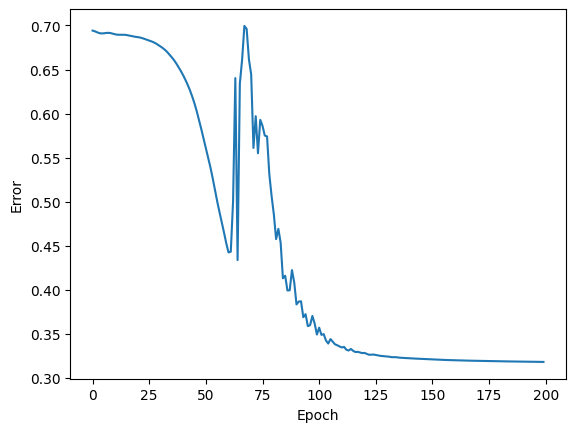

In [ ]:
plt.plot(range(len(train_errors)),train_errors)
plt.xlabel("Epoch")
plt.ylabel("Error")

In [ ]:
test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
test_pred,y_test

(tensor([1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
         1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
         0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
         1, 1, 0, 1, 1, 0, 0, 1]),
 tensor([1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
         1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
         0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
         1, 1, 0, 1, 1, 0, 0, 1]))

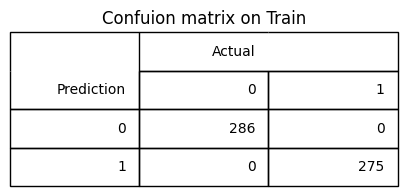

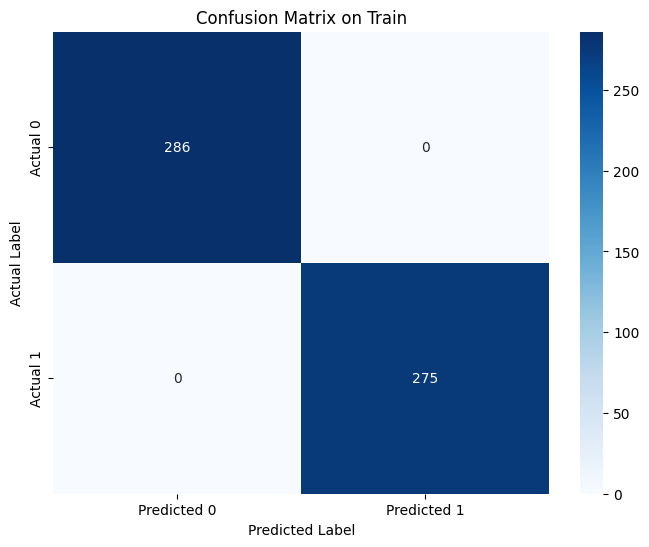

In [ ]:
_,_,test_logits = model(X_train)
train_pred = test_logits.argmax(dim=1)
create_table(y_train,train_pred,labels=[0,1],title="Confuion matrix on Train")


import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_train contains the true labels and train_pred contains the predicted labels
y_train = np.array(y_train)  # Convert to numpy array if it's not already
train_pred = np.array(train_pred)  # Convert to numpy array if it's not already

# Create confusion matrix
cm = confusion_matrix(y_train, train_pred, labels=[0, 1])

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title("Confusion Matrix on Train")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


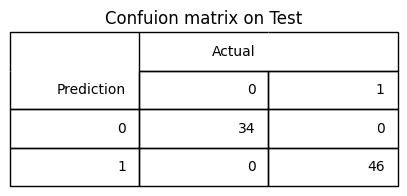

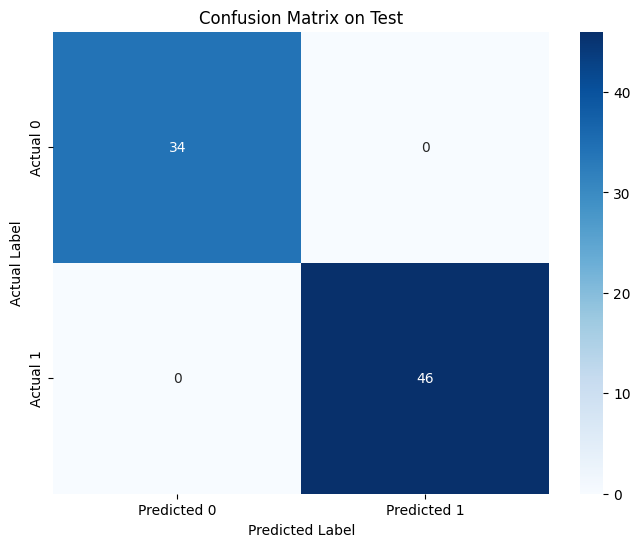

In [ ]:
create_table(y_test,test_pred,labels=[0,1],title="Confuion matrix on Test")
# Assuming y_test contains the true labels and test_pred contains the predicted labels
y_test = np.array(y_test)  # Convert to numpy array if it's not already
test_pred = np.array(test_pred)  # Convert to numpy array if it's not already

# Create confusion matrix
cm_test = confusion_matrix(y_test, test_pred, labels=[0, 1])

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title("Confusion Matrix on Test")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

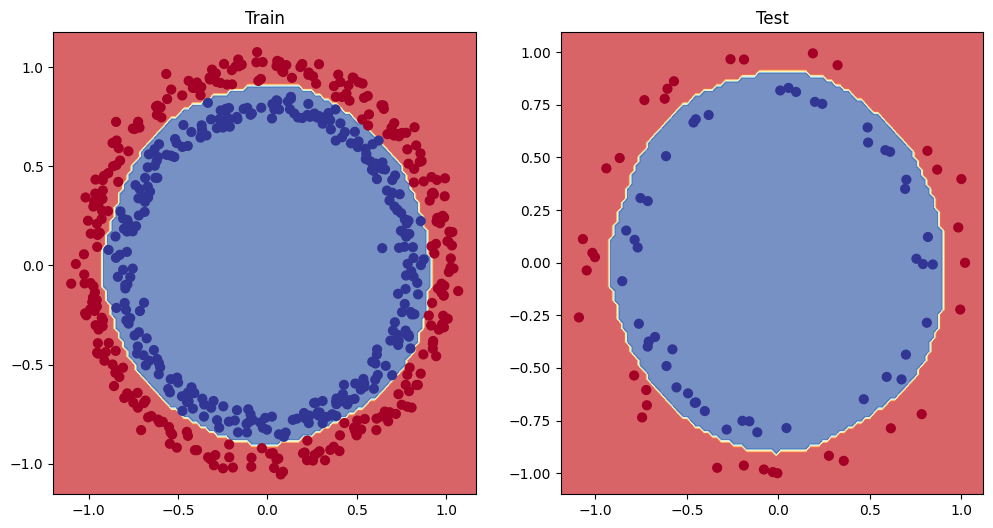

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

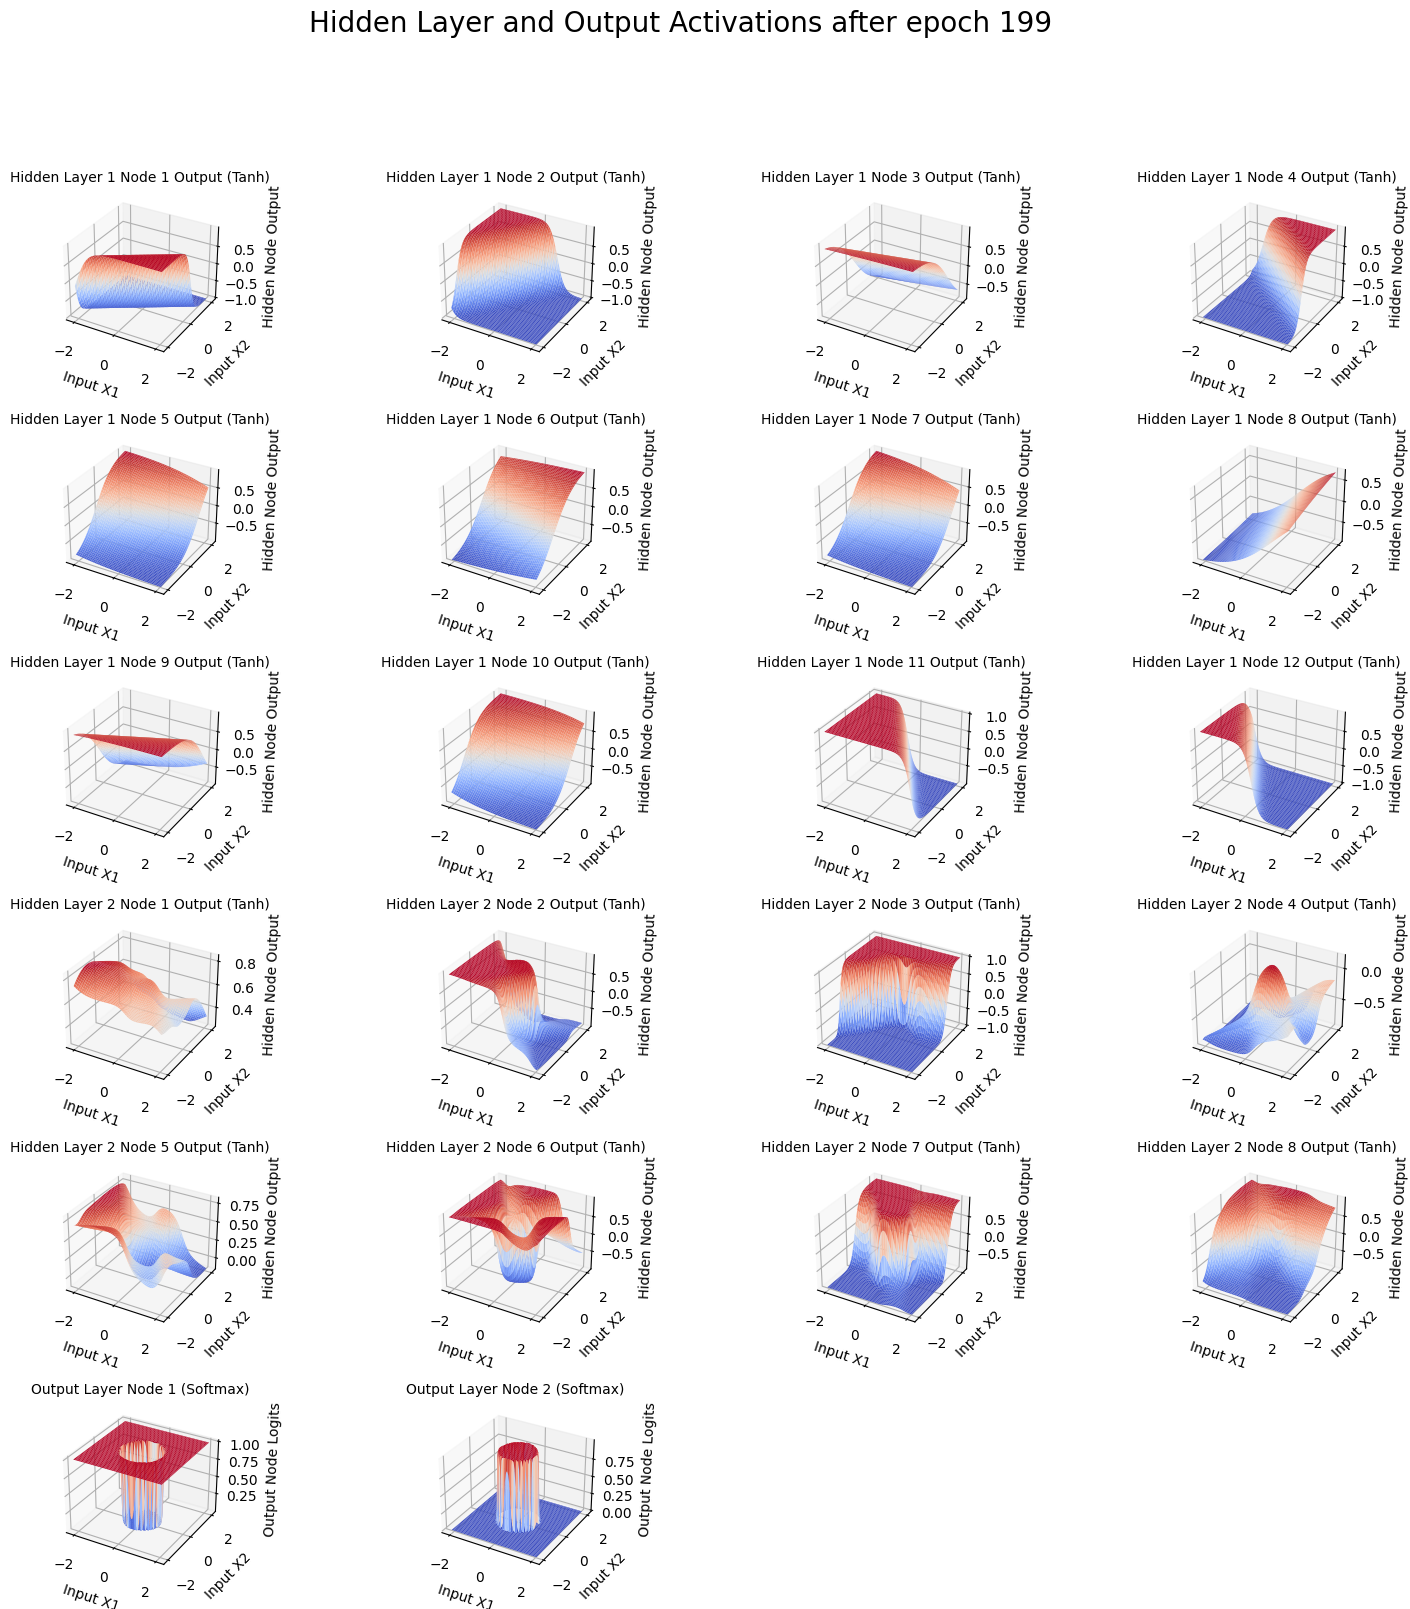

In [ ]:
showgraphs(model, X_train, n_hidden1=12, n_hidden2=8, n_output=2,epoch=epoch)